# Assignment 1. Music Century Classification

**Assignment Responsible**: Natalie Lang.

In this assignment, we will build models to predict which
**century** a piece of music was released.  We will be using the "YearPredictionMSD Data Set"
based on the Million Song Dataset. The data is available to download from the UCI 
Machine Learning Repository. Here are some links about the data:

- https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd
- http://millionsongdataset.com/pages/tasks-demos/#yearrecognition

Note that you are note allowed to import additional packages **(especially not PyTorch)**. One of the objectives is to understand how the training procedure actually operates, before working with PyTorch's autograd engine which does it all for us.


## Question 1. Data (21%)

Start by setting up a Google Colab notebook in which to do your work.
Since you are working with a partner, you might find this link helpful:

- https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb

The recommended way to work together is pair coding, where you and your partner are sitting together and writing code together. 

To process and read the data, we use the popular `pandas` package for data analysis.

In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

Now that your notebook is set up, we can load the data into the notebook. The code below provides
two ways of loading the data: directly from the internet, or through mounting Google Drive.
The first method is easier but slower, and the second method is a bit involved at first, but
can save you time later on. You will need to mount Google Drive for later assignments, so we recommend
figuring how to do that now.

Here are some resources to help you get started:

- http.://colab.research.google.com/notebooks/io.ipynb

In [3]:
load_from_drive = True

if not load_from_drive:
  csv_path = "http://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip"
else:
  from google.colab import drive
  drive.mount('/content/gdrive')
  csv_path = '/content/gdrive/My Drive/DL/YearPredictionMSD.txt.zip' # TODO - UPDATE ME WITH THE TRUE PATH!

t_label = ["year"]
x_labels = ["var%d" % i for i in range(1, 91)]
df = pandas.read_csv(csv_path, names=t_label + x_labels)

Mounted at /content/gdrive


Now that the data is loaded to your Colab notebook, you should be able to display the Pandas
DataFrame `df` as a table:

In [4]:
df

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.0500

To set up our data for classification, we'll use the "year" field to represent
whether a song was released in the 20-th century. In our case `df["year"]` will be 1 if
the year was released after 2000, and 0 otherwise.

In [5]:
df["year"] = df["year"].map(lambda x: int(x > 2000))

In [6]:
df.head(20)

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,1,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,1,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,1,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,1,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,1,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34

### Part (a) -- 7%

The data set description text asks us to respect the below train/test split to
avoid the "producer effect". That is, we want to make sure that no song from a single artist
ends up in both the training and test set.

Explain why it would be problematic to have
some songs from an artist in the training set, and other songs from the same artist in the
test set. (Hint: Remember that we want our test accuracy to predict how well the model
will perform in practice on a song it hasn't learned about.)

In [7]:
df_train = df[:463715]
df_test = df[463715:]

# convert to numpy
train_xs = df_train[x_labels].to_numpy()
train_ts = df_train[t_label].to_numpy()
test_xs = df_test[x_labels].to_numpy()
test_ts = df_test[t_label].to_numpy()

# Write your explanation here
# When we develop a neural network, we want it to be as general as possible, and able to process new information that is not similar to the data that was used for the training, for example, new artists.
# In a case that the training set and test set both contain songs from the same artist (similar characteristics in both data sets), we will possibly get good performance, but we wouldn't know how well the network
# will perform on different data. We could get a network which is "overfitted" for the data that was used in the training, and we wouldn't know it.

### Part (b) -- 7%

It can be beneficial to **normalize** the columns, so that each column (feature)
has the *same* mean and standard deviation.

In [8]:
feature_means = df_train.mean()[1:].to_numpy() # the [1:] removes the mean of the "year" field
feature_stds  = df_train.std()[1:].to_numpy()

train_norm_xs = (train_xs - feature_means) / feature_stds
test_norm_xs = (test_xs - feature_means) / feature_stds

Notice how in our code, we normalized the test set using the *training data means and standard deviations*.
This is *not* a bug.

Explain why it would be improper to compute and use test set means
and standard deviations. (Hint: Remember what we want to use the test accuracy to measure.)

In [9]:
# Write your explanation here
# In order to examine the performance of our trained network, we use a test set.
# This action is supposed to simulate "real" data that the network will receive. With real data, we won't have prior knowledge about its statistical properties.

### Part (c) -- 7%

Finally, we'll move some of the data in our training set into a validation set.

Explain why we should limit how many times we use the test set, and that we should use the validation
set during the model building process.

In [10]:
# shuffle the training set
reindex = np.random.permutation(len(train_xs))
train_xs = train_xs[reindex]
train_norm_xs = train_norm_xs[reindex]
train_ts = train_ts[reindex]

# use the first 50000 elements of `train_xs` as the validation set
train_xs, val_xs           = train_xs[50000:], train_xs[:50000]
train_norm_xs, val_norm_xs = train_norm_xs[50000:], train_norm_xs[:50000]
train_ts, val_ts           = train_ts[50000:], train_ts[:50000]

# Write your explanation here
# The test set shouldn't be used too many times when design the NN, in order to avoid a situation where we design our network mainly by the test set. This could lead to a non-general network, which will perform not as good
# on real data as on the test set.
# When we build the model, we keep some of the data out of the training process in order to examine the network's performance and change its hyperparametes accordingly. Only after we believe the model is ready, we should
# test it by using the test set.

## Part 2. Classification (79%)

We will first build a *classification* model to perform decade classification.
These helper functions are written for you. All other code that you write in this section should be vectorized whenever possible (i.e., avoid unnecessary loops).

In [11]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))
    
def cross_entropy(t, y):
  return -t * np.log(y + 10**-2) - (1 - t) * np.log(1 - y + 10**-2)

def cost(y, t):
  return np.mean(cross_entropy(t, y))

def get_accuracy(y, t):
  acc = 0
  N = 0
  for i in range(len(y)):
    N += 1
    if (y[i] >= 0.5 and t[i] == 1) or (y[i] < 0.5 and t[i] == 0):
      acc += 1
  return acc / N

### Part (a) -- 7%

Write a function `pred` that computes the prediction `y` based on logistic regression, i.e., a single layer with weights `w` and bias `b`. The output is given by: 
\begin{equation}
y = \sigma({\bf w}^T {\bf x} + b),
\end{equation}
where the value of $y$ is an estimate of the probability that the song is released in the current century, namely ${\rm year} =1$.

In [12]:
def pred(w, b, X):
  """
  Returns the prediction `y` of the target based on the weights `w` and scalar bias `b`.

  Preconditions: np.shape(w) == (90,)
                 type(b) == float
                 np.shape(X) = (N, 90) for some N

  >>> pred(np.zeros(90), 1, np.ones([2, 90]))
  array([0.73105858, 0.73105858]) # It's okay if your output differs in the last decimals
  """
  # Your code goes here 
  y = sigmoid(w @ X.T + b)
  return y
pred(np.zeros(90), 1, np.ones([2, 90]))

array([0.73105858, 0.73105858])

### Part (b) -- 7%

Write a function `derivative_cost` that computes and returns the gradients 
$\frac{\partial\mathcal{L}}{\partial {\bf w}}$ and
$\frac{\partial\mathcal{L}}{\partial b}$. Here, `X` is the input, `y` is the prediction, and `t` is the true label.




In [13]:
def derivative_cost(X, y, t):
  """
  Returns a tuple containing the gradients dLdw and dLdb.

  Precondition: np.shape(X) == (N, 90) for some N
                np.shape(y) == (N,)
                np.shape(t) == (N,)

  Postcondition: np.shape(dLdw) = (90,)
           type(dLdb) = float
  """
  # Your code goes here
  # dsigmoiddx =y*(1-y)
  # grad_L = dLdy.*dsigmoiddx
  # N = np.shape(X)[1]

  g = y - t
  
  dLdw = g @ X / len(g)
  dLdb = g @ np.ones(np.shape(g)) / len(g)
  return (dLdw, dLdb)

# **Explenation on Gradients**




**Add here an explaination on how the gradients are computed**:

The lost function is given by: $L(y,t) = -t log(y) - (1-t) log (1-y)$

where: $y = σ(w^TX+b)$ and $t$ is the true label.

We would like to calculate the derivatives $\frac{dL}{dw}$ and $\frac{dL}{db}$

we will define $z=w^TX+b$ and by using the chain rule for derivatives, we will get: $$\frac{dL}{dw} = \frac{dL}{dy}\frac{dy}{dz}\frac{dz}{dw}$$

and: $$\frac{dL}{db} = \frac{dL}{dy}\frac{dy}{dz}\frac{dz}{db}$$

After calculation, each element is given by: $$\frac{dL}{dy} = \frac{y - t}{y(1-y)}$$ $$\frac{dy}{dz} = y(1-y)$$ $$\frac{dz}{dw} = X$$ $$\frac{dz}{db} = 1$$

After placing the terms and reduction, we will get: $$\frac{dL}{dw} = (y - t)X^T$$ $$\frac{dL}{db} = (y - t)$$

Write your explanation here. Use Latex to write mathematical expressions. [Here is a brief tutorial on latex for notebooks.](https://www.math.ubc.ca/~pwalls/math-python/jupyter/latex/)



### Part (c) -- 7%

We can check that our derivative is implemented correctly using the finite difference rule. In 1D, the
finite difference rule tells us that for small $h$, we should have

$$\frac{f(x+h) - f(x)}{h} \approx f'(x)$$

Show that $\frac{\partial\mathcal{L}}{\partial b}$  is implement correctly
by comparing the result from `derivative_cost` with the empirical cost derivative computed using the above numerical approximation.


In [14]:
# Your code goes here

X = np.ones([2, 90]) * 2
t = np.array([1, 1])
w = np.random.randn(90)
b = 1
y = pred(w,b,X)

r1 = derivative_cost(X, y, t)[1]

h = 0.001
y_tag = pred(w,b+h,X)
r2 = np.average((cross_entropy(t, y_tag) - cross_entropy(t, y)) / h)
print("The analytical results is -", r1)
print("The algorithm results is - ", r2)


The analytical results is - -0.9999976103013516
The algorithm results is -  -0.00023903166734839942


### Part (d) -- 7%

Show that $\frac{\partial\mathcal{L}}{\partial {\bf w}}$  is implement correctly.

In [15]:
# Your code goes here. You might find this below code helpful: but it's
# up to you to figure out how/why, and how to modify the code

r1 =  derivative_cost(X, y, t)[0]

r2 = np.zeros(np.size(r1))
for i in range(0,len(w)):
  step = np.zeros(np.size(w))
  step[i] = h
  y_tag = pred(w+step,b,X)

  r2[i] = np.average((cross_entropy(t, y_tag) - cross_entropy(t, y)) / h)
print("The analytical results is -", r1)
print("The algorithm results is - ", r2)


The analytical results is - [-1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522
 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522
 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522
 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522
 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522
 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522
 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522
 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522
 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522
 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522
 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522
 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522
 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522 -1.99999522
 -1.99999522 -1.9999952

### Part (e) -- 7%

Now that you have a gradient function that works, we can actually run gradient descent. 
Complete the following code that will run stochastic: gradient descent training:

In [16]:
def run_gradient_descent(w0, b0, train_norm_xs, train_ts, val_norm_xs, val_ts, mu=0.1, batch_size=100, max_iters=100):
  """Return the values of (w, b) after running gradient descent for max_iters.
  We use:
    - train_norm_xs and train_ts as the training set
    - val_norm_xs and val_ts as the test set
    - mu as the learning rate
    - (w0, b0) as the initial values of (w, b)

  Precondition: np.shape(w0) == (90,)
                type(b0) == float
 
  Postcondition: np.shape(w) == (90,)
                 type(b) == float
  """
  w = w0
  b = b0
  iter = 0

  while iter < max_iters:
    # shuffle the training set (there is code above for how to do this)
    reindex = np.random.permutation(len(train_norm_xs))
    train_norm_xs = train_norm_xs[reindex]
    train_ts = train_ts[reindex]
    loss_vec = []

    for i in range(0, len(train_norm_xs), batch_size): # iterate over each minibatch
      # minibatch that we are working with:
      X = train_norm_xs[i:(i + batch_size)]
      t = train_ts[i:(i + batch_size), 0]
      # since len(train_norm_xs) does not divide batch_size evenly, we will skip over
      # the "last" minibatch
      if np.shape(X)[0] != batch_size:
        continue

      # compute the prediction
      y = pred(w, b, X)

      # update w and b
      (dLdw, dLdb) = derivative_cost(X, y, t)
      w = w - mu * dLdw
      b = b - mu * dLdb
      # increment the iteration count
      iter += 1
      # compute and print the *validation* loss and accuracy
      if (iter % 10 == 0):
        X_val = val_norm_xs
        y_val = pred(w, b, X_val)
        t_val = val_ts[:, 0]
        val_cost = cost(y_val, t_val)
        val_acc = get_accuracy(y_val, t_val)
        loss_vec.append(val_cost)
        # print("Iter %d. [Val Acc %.0f%%, Loss %f]" % (
        #         iter, val_acc * 100, val_cost))

      if iter >= max_iters:
        break

      # Think what parameters you should return for further use
      
  return (w, b, loss_vec)



### Part (f) -- 7%

Call `run_gradient_descent` with the weights and biases all initialized to zero.
Show that if the learning rate $\mu$ is too small, then convergence is slow.
Also, show that if $\mu$ is too large, then the optimization algorirthm does not converge. The demonstration should be made using plots showing these effects.

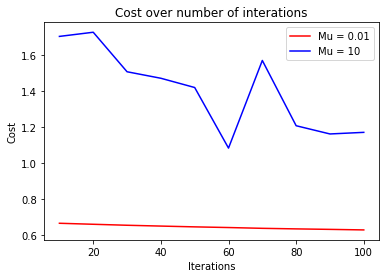

In [17]:
# w0 = np.random.randn(90)
# b0 = np.random.randn(1)[0]
w0 = np.zeros(90)
b0 = 0

# Write your code here
(w,b,loss_01) = run_gradient_descent(w0, b0, train_norm_xs, train_ts, val_norm_xs, val_ts, 0.01)
(w,b,loss_10) = run_gradient_descent(w0, b0, train_norm_xs, train_ts, val_norm_xs, val_ts, 10)
iter_vec = range(10,110,10)
plt.plot(iter_vec, loss_01, 'r')
plt.plot(iter_vec, loss_10, 'b')
plt.legend(["Mu = 0.01", "Mu = 10"])
plt.title("Cost over number of interations")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

**Explain and discuss your results here:**

The learning rate is responsible for the change of the parameters (w,b) in each iteration: $$w = w - \mu \frac{dL}{dw}, b = b - \mu \frac{dL}{db}$$
As we can see, with a relatively small learning rate, we get a moderate convergence to the minimum. This is because the change in each iteration will be minor.

In contrast to that, when we took a large learning rate, we didn't get a convergance. This is because the change of the parameters was major, so we possibly "skipped" the minimum



### Part (g) -- 7%

Find the optimial value of ${\bf w}$ and $b$ using your code. Explain how you chose
the learning rate $\mu$ and the batch size. Show plots demostrating good and bad behaviours.

In [20]:
best_loss = 10
for j in range(20,40):
  mu = j / 100
  print(f"Running gradient descent with mu = {mu}")
  w0 = np.zeros(90)
  b0 = 0
  for i in range(1,20):
    (w,b,loss_vec) = run_gradient_descent(w0, b0, train_norm_xs, train_ts, val_norm_xs, val_ts, mu)
    if loss_vec[-1] < best_loss:
      best_w = w
      best_b = b
      best_loss = loss_vec[-1]
      best_mu = mu
    w0 = np.random.randn(90)
    b0 = np.random.randn(1)[0]

print(f"w = {best_w}, b = {best_b}, loss = {best_loss}, mu = {best_mu}")

Running gradient descent with mu = 0.2
Running gradient descent with mu = 0.21
Running gradient descent with mu = 0.22
Running gradient descent with mu = 0.23
Running gradient descent with mu = 0.24
Running gradient descent with mu = 0.25
Running gradient descent with mu = 0.26
Running gradient descent with mu = 0.27
Running gradient descent with mu = 0.28
Running gradient descent with mu = 0.29
Running gradient descent with mu = 0.3
Running gradient descent with mu = 0.31
Running gradient descent with mu = 0.32
Running gradient descent with mu = 0.33
Running gradient descent with mu = 0.34
Running gradient descent with mu = 0.35
Running gradient descent with mu = 0.36
Running gradient descent with mu = 0.37
Running gradient descent with mu = 0.38
Running gradient descent with mu = 0.39
w = [ 0.98586598 -0.58659167 -0.12121531 -0.16976825 -0.04881511 -0.40306108
  0.12709435 -0.09841618 -0.10567405 -0.00619769 -0.05243885 -0.05641314
  0.10457355  0.18693449 -0.08695331  0.16476137  0.

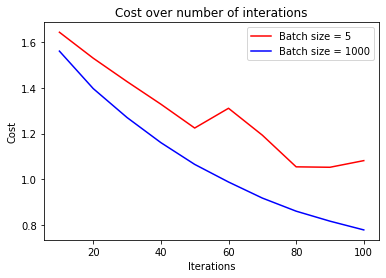

In [24]:
w0 = np.random.randn(90)
b0 = np.random.randn(1)[0]
(w,b,loss_vec_batch_5) = run_gradient_descent(w0, b0, train_norm_xs, train_ts, val_norm_xs, val_ts, 0.27, 5) # small batch size
(w,b,loss_vec_batch_1000) = run_gradient_descent(w0, b0, train_norm_xs, train_ts, val_norm_xs, val_ts, 0.27, 1000) # large batch size
iter_vec = range(10,110,10)
plt.plot(iter_vec, loss_vec_batch_5, 'r')
plt.plot(iter_vec, loss_vec_batch_1000, 'b')
plt.legend(["Batch size = 5", "Batch size = 1000"])
plt.title("Cost over number of interations")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

**Explain and discuss your results here:**

In order to find the optimal parameters, we ran the gradient descent algorithm with different learning rates from 0.2 to 0.4 and random initilizations, and chose the ones that achieved the lowest loss.

In addition, as we can see with a small batch size, we get higher values of the loss, meaning less accuracy. The learning curve is not monotonically decreasing, and it's noisier. When we run the algorithm with a large batch size, we get good results but it is more computationally expensive and takes more time.

We chose a medium batch size of 100.



### Part (h) -- 15%

Using the values of `w` and `b` from part (g), compute your training accuracy, validation accuracy,
and test accuracy. Are there any differences between those three values? If so, why?

In [25]:
# Write your code here

train_acc = get_accuracy(pred(best_w,best_b,train_norm_xs), train_ts[:,0])
val_acc = get_accuracy(pred(best_w,best_b,val_norm_xs), val_ts[:,0])
test_acc = get_accuracy(pred(best_w,best_b,test_norm_xs), test_ts[:,0])

print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)


train_acc =  0.719359945856447  val_acc =  0.7215  test_acc =  0.7124539996126283


**Explain and discuss your results here:**

We would expect the training set to have the best accuracy, because this is the data that was used to calculate the parameters. Also, we expect the validation set accuracy to be high, because we chose which parameters are optimal by it.
In this case, we see there is a negligible advantage to the validation set.

The test set contains new data that the application hasn't seen, so the accuracy with this data set should be the lowest, like we recieved. 

### Part (i) -- 15%

Writing a classifier like this is instructive, and helps you understand what happens when
we train a model. However, in practice, we rarely write model building and training code
from scratch. Instead, we typically use one of the well-tested libraries available in a package.

Use `sklearn.linear_model.LogisticRegression` to build a linear classifier, and make predictions about the test set. Start by reading the
[API documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Compute the training, validation and test accuracy of this model.

In [26]:
import sklearn.linear_model

model = sklearn.linear_model.LogisticRegression(random_state=0).fit(train_norm_xs, train_ts[:,0])

train_acc = model.score(train_norm_xs, train_ts[:,0])
val_acc = model.score(val_norm_xs, val_ts[:,0])
test_acc = model.score(test_norm_xs, test_ts[:,0])

print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)

train_acc =  0.7326517046759242  val_acc =  0.73386  test_acc =  0.7262638001162115


**This parts helps by checking if the code worked.**
**Check if you get similar results, if not repair your code**
